Анализ

Подключим все библиотеки, которые нам понадобятся для работы с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Установим опции, чтобы вывод таблицы был без переносов на новую строку

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',50)

In [3]:
train=pd.read_csv('C:/Users/titen/PycharmProjects/Neural-Networks-Projects-1/data/train1.csv') 
test=pd.read_csv('C:/Users/titen/PycharmProjects/Neural-Networks-Projects-1/data/test1.csv') 
print(train.head())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  Transported
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy        False
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False        109.0        9.0          25.0   549.0    44.0       Juanna Vines         True
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True         43.0     3576.0           0.0  6715.0    49.0      Altark Susent        False
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False          0.0     1283.0         371.0  3329.0   193.0       Solam Susent        False
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False        303.0       70.0         151.0   565.0     2.0  Willy Santantines         True


Переведем для удобства данные ключевого столбца в целочисленный тип 

In [4]:
train['Transported']=train['Transported'].astype(int)

У нас имеется столбец, в котором указаны кабины пассажиров, представленные в виде deck/num/side
Разделим данные на три разных столбца с номером палубы, каюты и стороной в части корабля 

In [5]:
train['Cabin_Deck'] = train['Cabin'].str.split('/').str[0]
train['Cabin_Number'] = train['Cabin'].str.split('/').str[1].astype(float)
train['Cabin_Side'] = train['Cabin'].str.split('/').str[2]
print(train[['Cabin','Cabin_Deck','Cabin_Number', 'Cabin_Side']].head())

   Cabin Cabin_Deck  Cabin_Number Cabin_Side
0  B/0/P          B           0.0          P
1  F/0/S          F           0.0          S
2  A/0/S          A           0.0          S
3  A/0/S          A           0.0          S
4  F/1/S          F           1.0          S


Также у нас есть номер пассажира PassengerId, представленный в виде gggg_pp. 
Разделим его на номер группы и номер человека в группе и сформируем столбец с количеством человек в заданной группе

In [6]:
train['Group_Id'] = train['PassengerId'].str.split('_').str[0]
train['Person_Id'] = train['PassengerId'].str.split('_').str[1].astype(int)
train['GroupSize'] = train['Group_Id'].map(train['Group_Id'].value_counts())
print(train[['PassengerId','Group_Id','Person_Id', 'GroupSize']].head())

  PassengerId Group_Id  Person_Id  GroupSize
0     0001_01     0001          1          1
1     0002_01     0002          1          1
2     0003_01     0003          1          2
3     0003_02     0003          2          2
4     0004_01     0004          1          1


Далее будем проводить анализ с помощью составления матрицы корреляции. 
Для этого разделим данные в потенциально значимых столбцах по значениям и удалим ненужные на данном этапе столбцы

In [7]:
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']
train_sep = pd.get_dummies(train, columns=cat_cols)
train_sep_dropp = train_sep.drop(['PassengerId', 'Cabin', 'Name', 'Group_Id'], axis=1)

In [8]:
train_sep_dropp['Transported']=train_sep_dropp['Transported'].astype(int)

Составим матрицу корреляции и будем изучать значимую для нас столбец (строку) Transported

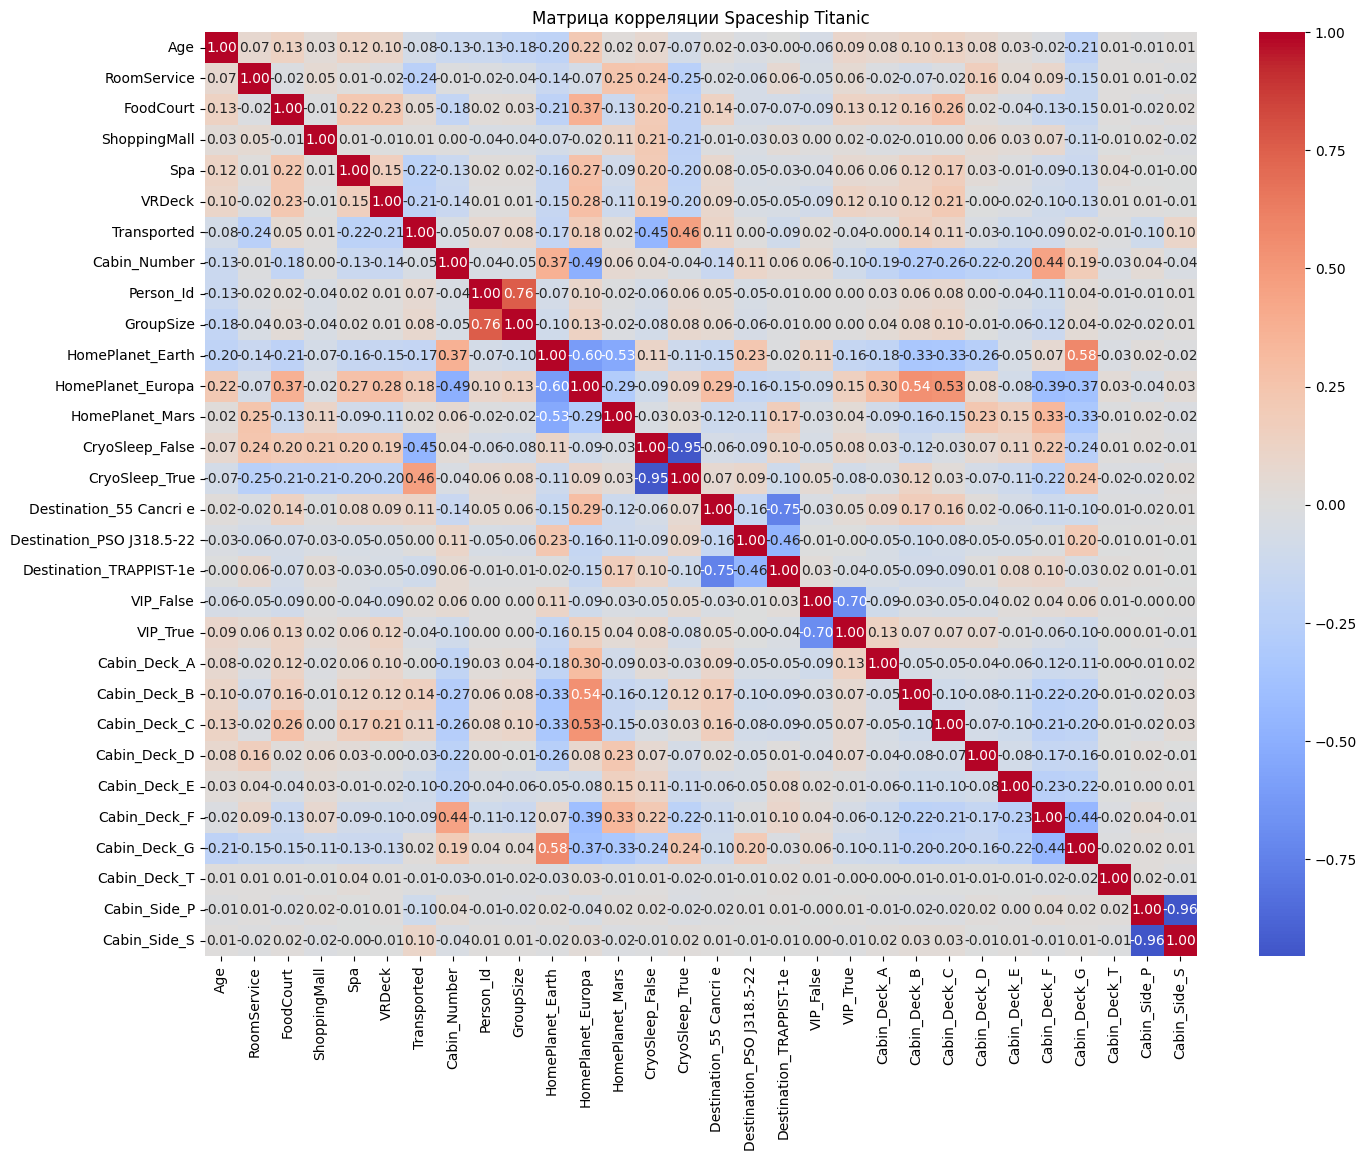

In [9]:
corr1 = train_sep_dropp.corr(numeric_only=True)
plt.figure(figsize=(16, 12))
sns.heatmap(corr1, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляции Spaceship Titanic')
plt.show()

Выведем значимые для анализа признаки, а также признаки, которые мы можем исключать из-за небольшого влияния на столбец Transported

In [10]:
transported_corr = corr1['Transported'].sort_values(ascending=False)
good_features=transported_corr[(abs(transported_corr)>0.04)&(transported_corr.index != 'Transported')]
print("Important features for modeling:")
print(good_features.sort_values(ascending=False))
bad_features=transported_corr[abs(transported_corr)<=0.04]
print("\n Candidates for deleting:")
print(bad_features)

Important features for modeling:
CryoSleep_True             0.460132
HomePlanet_Europa          0.176916
Cabin_Deck_B               0.144733
Destination_55 Cancri e    0.108722
Cabin_Deck_C               0.108193
Cabin_Side_S               0.101455
GroupSize                  0.082644
Person_Id                  0.066390
FoodCourt                  0.046566
Cabin_Number              -0.045097
Age                       -0.075026
Cabin_Deck_F              -0.087753
Destination_TRAPPIST-1e   -0.094700
Cabin_Deck_E              -0.097965
Cabin_Side_P              -0.101397
HomePlanet_Earth          -0.169019
VRDeck                    -0.207075
Spa                       -0.221131
RoomService               -0.244611
CryoSleep_False           -0.451744
Name: Transported, dtype: float64

 Candidates for deleting:
VIP_False                    0.024602
HomePlanet_Mars              0.019544
Cabin_Deck_G                 0.016269
ShoppingMall                 0.010141
Destination_PSO J318.5-22    0.000

In [11]:
print(train.head())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  Transported Cabin_Deck  Cabin_Number Cabin_Side Group_Id  Person_Id  GroupSize
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy            0          B           0.0          P     0001          1          1
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False        109.0        9.0          25.0   549.0    44.0       Juanna Vines            1          F           0.0          S     0002          1          1
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True         43.0     3576.0           0.0  6715.0    49.0      Altark Susent            0          A           0.0          S     0003          1          2
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False          0.0     1283.0         371.0  3329.0   

Основываясь на данном списке, удалим незначимые столбцы.

In [12]:
def preprocess_basic(df):
    if 'Transported' in df:
        df['Transported']=df['Transported'].astype(int)
    extra_columns=['Cabin', 'Name', 'Group_Id','ShoppingMall','Cabin_Number', 'VIP']
    df=df.drop(columns=extra_columns, axis=1)
    return df

In [13]:
def preprocess_separate(df):
    df['Cabin_Deck'] = df['Cabin'].str.split('/').str[0]
    df['Cabin_Number'] = df['Cabin'].str.split('/').str[1].astype(float)
    df['Cabin_Side'] = df['Cabin'].str.split('/').str[2]
    df['Group_Id'] = df['PassengerId'].str.split('_').str[0]
    df['Person_Id'] = df['PassengerId'].str.split('_').str[1].astype(int)
    df['GroupSize'] = df['Group_Id'].map(df['Group_Id'].value_counts())
    return df

Далее будем работать над упрощением признаков и заполнением отсутствуюших значений. Начнем со столбца возрастов
Построим гистограммы, отражающие выживаемость и невыживаемость для всех возрастов

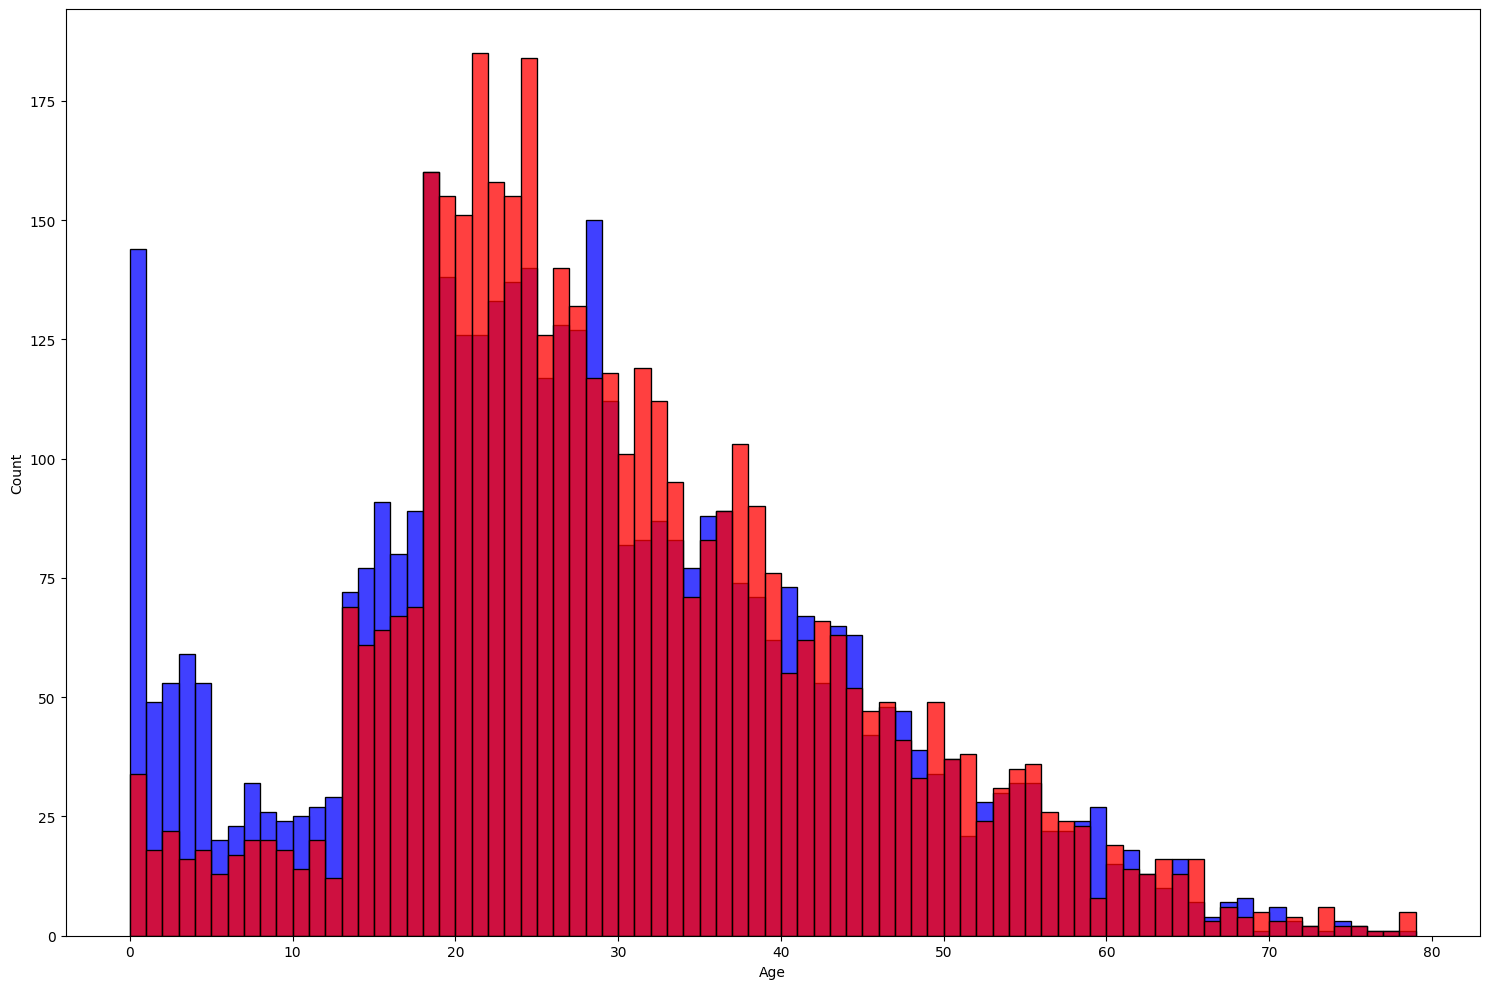

In [14]:
fig2 = plt.figure(figsize=(15,10))
ax=fig2.add_subplot(111)
transported = train[train['Transported'] == 1]
not_transported = train[train['Transported'] == 0]
sns.histplot(data=transported['Age'].dropna(), bins=range(0, 80, 1), kde=False, color='blue', ax=ax)
sns.histplot(data=not_transported['Age'].dropna(), bins=range(0, 80, 1), kde=False, color='red', ax=ax)
ax.set_xlabel('Age')
plt.tight_layout()
plt.show()

In [15]:
print(train['HomePlanet'].value_counts())
print(train['HomePlanet'].isnull().sum())

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64
201


In [16]:
print(train['Destination'].value_counts())
print(train['Destination'].isnull().sum())

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64
182


Заполним пропуски

In [17]:
def preprocess_fillna(df):
    #Age
    age_avg = df['Age'].mean()
    age_std = df['Age'].std()
    age_nan_count = df['Age'].isnull().sum()
    np.random.seed(42)
    age_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_nan_count)
    null_indices=df['Age'].isnull()
    df.loc[null_indices, 'Age'] = age_random_list
    df['Age'] = df['Age'].astype(int)

    df.loc[(df[['RoomService','Spa','VRDeck','FoodCourt']]>0).any(axis=1), 'CryoSleep'] = 0   
    df.loc[((df['CryoSleep']==1)|(df['CryoSleep']==True)), ['RoomService', 'VRDeck','FoodCourt', 'Spa']] = 0 
    
    df['CryoSleep'] = df['CryoSleep'].fillna(0).astype(int)
    df['HomePlanet']=df['HomePlanet'].fillna('Earth')
    df['Destination']=df['Destination'].fillna('TRAPPIST-1e')

    df['RoomService']=df['RoomService'].fillna(df['RoomService'].median())
    df['Spa']=df['Spa'].fillna(df['Spa'].median())
    df['VRDeck']=df['VRDeck'].fillna(df['VRDeck'].median())
    df['FoodCourt']=df['FoodCourt'].fillna(df['FoodCourt'].median())

    #train_dropp['Cabin_Side'] = train_dropp['Cabin_Side'].fillna('S')
    empty_indexes = df[df['Cabin_Side'].isnull()].index
    number_of_filled=round(df['Cabin_Side'].isnull().sum()/2)
    df.loc[empty_indexes[:number_of_filled], 'Cabin_Side'] = 'S'
    df.loc[empty_indexes[number_of_filled:], 'Cabin_Side'] = 'P'
    
    df['Cabin_Deck']=df['Cabin_Deck'].fillna('A')
    
    return df

In [18]:
def preprocess_categorial(df):
    
    df.loc[df['Age'] <= 15.8, 'Age'] = 0
    df.loc[(df['Age'] > 15.8)&(df['Age'] <=31.6), 'Age'] = 1
    df.loc[(df['Age'] > 31.6)&(df['Age'] <=47.4), 'Age'] = 2
    df.loc[(df['Age'] > 47.4)&(df['Age'] <=63.2), 'Age'] = 3
    df.loc[df['Age'] > 63.2, 'Age'] = 4

    home_mapping={"Earth": 1, "Europa": 2, "Mars": 3}
    df['HomePlanet'] = df['HomePlanet'].map(home_mapping)
    
    dest_mapping = {"TRAPPIST-1e": 1 , "55 Cancri e": 2 , "PSO J318.5-22": 3 }
    df['Destination'] = df['Destination'].map(dest_mapping)

    df.loc[df['RoomService'] <= df['RoomService'].quantile(0.25), 'RoomServiceGroup'] = 0
    df.loc[(df['RoomService'] > df['RoomService'].quantile(0.25))&(df['RoomService'] <= df['RoomService'].quantile(0.50)), 'RoomServiceGroup'] = 1
    df.loc[(df['RoomService'] > df['RoomService'].quantile(0.50))&(df['RoomService'] <= df['RoomService'].quantile(0.75)), 'RoomServiceGroup'] = 2
    df.loc[df['RoomService'] > df['RoomService'].quantile(0.75), 'RoomServiceGroup'] = 3
    df['RoomServiceGroup']=df['RoomServiceGroup'].astype(int)
    
    df.loc[df['Spa'] <= df['Spa'].quantile(0.25), 'SpaGroup'] = 0
    df.loc[(df['Spa'] > df['Spa'].quantile(0.25))&(df['Spa'] <= df['Spa'].quantile(0.50)), 'SpaGroup'] = 1
    df.loc[(df['Spa'] > df['Spa'].quantile(0.50))&(df['Spa'] <= df['Spa'].quantile(0.75)), 'SpaGroup'] = 2
    df.loc[df['Spa'] > df['Spa'].quantile(0.75), 'SpaGroup'] = 3
    df['SpaGroup']=df['SpaGroup'].astype(int)

    df.loc[df['VRDeck'] <= df['VRDeck'].quantile(0.25), 'VRDeckGroup'] = 0
    df.loc[(df['VRDeck'] > df['VRDeck'].quantile(0.25))&(df['VRDeck'] <= df['VRDeck'].quantile(0.50)), 'VRDeckGroup'] = 1
    df.loc[(df['VRDeck'] > df['VRDeck'].quantile(0.50))&(df['VRDeck'] <= df['VRDeck'].quantile(0.75)), 'VRDeckGroup'] = 2
    df.loc[df['VRDeck'] > df['VRDeck'].quantile(0.75), 'VRDeckGroup'] = 3
    df['VRDeckGroup']=df['VRDeckGroup'].astype(int)

    df.loc[df['FoodCourt'] <= df['FoodCourt'].quantile(0.25), 'FoodCourtGroup'] = 0
    df.loc[(df['FoodCourt'] > df['FoodCourt'].quantile(0.25))&(df['FoodCourt'] <= df['FoodCourt'].quantile(0.50)), 'FoodCourtGroup'] = 1
    df.loc[(df['FoodCourt'] > df['FoodCourt'].quantile(0.50))&(df['FoodCourt'] <= df['FoodCourt'].quantile(0.75)), 'FoodCourtGroup'] = 2
    df.loc[df['FoodCourt'] > df['FoodCourt'].quantile(0.75), 'FoodCourtGroup'] = 3
    df['FoodCourtGroup']=df['FoodCourtGroup'].astype(int)

    df=df.drop(['Spa','VRDeck', 'RoomService','FoodCourt'], axis=1)

    df['Cabin_Side'] = df['Cabin_Side'].map({'P': 0, 'S': 1})
    df['Cabin_Side'] = df['Cabin_Side'].astype(int)  

    deck_mapping={'A' : 0, 'T' : 1, 'G' : 2, 'D' : 3,'F': 4, 'E' : 5, 'C' : 6, 'B' : 7}
    df['Cabin_Deck'] = df['Cabin_Deck'].map(deck_mapping).astype(int)
    
    return df

In [19]:
train_copy=train.copy()
train1=preprocess_separate(train_copy)
train1=preprocess_basic(train1)
train1=train1.drop('PassengerId', axis=1)
train1=preprocess_fillna(train1)
train1=preprocess_categorial(train1)
print(train1.head())
print(train1.isnull().sum())

   HomePlanet  CryoSleep  Destination  Age  Transported  Cabin_Deck  Cabin_Side  Person_Id  GroupSize  RoomServiceGroup  SpaGroup  VRDeckGroup  FoodCourtGroup
0           2          0            1    2            0           7           0          1          1                 0         0            0               0
1           1          0            1    1            1           4           1          1          1                 3         3            3               2
2           2          0            1    3            0           0           1          1          2                 3         3            3               3
3           2          0            1    2            0           0           1          2          2                 0         3            3               3
4           1          0            1    1            1           4           1          1          1                 3         3            2               3
HomePlanet          0
CryoSleep           0
De

In [20]:
test_copy=test.copy()
test1=preprocess_separate(test_copy)
test1=preprocess_basic(test1)
test1=preprocess_fillna(test1)
test1=preprocess_categorial(test1)
print(test1.head())
print(test1.isnull().sum())

  PassengerId  HomePlanet  CryoSleep  Destination  Age  Cabin_Deck  Cabin_Side  Person_Id  GroupSize  RoomServiceGroup  SpaGroup  VRDeckGroup  FoodCourtGroup
0     0013_01           1          1            1    1           2           1          1          1                 0         0            0               0
1     0018_01           1          0            1    1           4           1          1          1                 0         3            0               2
2     0019_01           2          1            2    1           6           1          1          1                 0         0            0               0
3     0021_01           2          0            1    2           6           1          1          1                 0         3            3               3
4     0023_01           1          0            1    1           4           1          1          1                 2         0            0               0
PassengerId         0
HomePlanet          0
CryoSlee

Итоговый вид таблицы train

In [21]:
print(train1.head())
print(train1.shape)

   HomePlanet  CryoSleep  Destination  Age  Transported  Cabin_Deck  Cabin_Side  Person_Id  GroupSize  RoomServiceGroup  SpaGroup  VRDeckGroup  FoodCourtGroup
0           2          0            1    2            0           7           0          1          1                 0         0            0               0
1           1          0            1    1            1           4           1          1          1                 3         3            3               2
2           2          0            1    3            0           0           1          1          2                 3         3            3               3
3           2          0            1    2            0           0           1          2          2                 0         3            3               3
4           1          0            1    1            1           4           1          1          1                 3         3            2               3
(8693, 13)


Итоговый вид таблицы test

In [22]:
print(test1.head())
print(test1.shape)

  PassengerId  HomePlanet  CryoSleep  Destination  Age  Cabin_Deck  Cabin_Side  Person_Id  GroupSize  RoomServiceGroup  SpaGroup  VRDeckGroup  FoodCourtGroup
0     0013_01           1          1            1    1           2           1          1          1                 0         0            0               0
1     0018_01           1          0            1    1           4           1          1          1                 0         3            0               2
2     0019_01           2          1            2    1           6           1          1          1                 0         0            0               0
3     0021_01           2          0            1    2           6           1          1          1                 0         3            3               3
4     0023_01           1          0            1    1           4           1          1          1                 2         0            0               0
(4277, 13)


МОДЕЛИРОВАНИЕ

Для прогнозирования транспортировки в таблице test будем использовать модель Случайного леса

In [23]:
from sklearn.ensemble import RandomForestClassifier

Далее составляем соотвутствующие матрицы, 
где X_train - признаки для обучения из тренировочного набора, y_train - ответы из тренировочного набора, соответсвующие признакам X_train
X_test - признаки из тестового набора, y_test - искомый вектор

In [24]:
X_train = train1.drop(['Transported'], axis=1)
y_train = train1['Transported']

correct_order=X_train.columns.tolist()
X_test = test1.drop(['PassengerId'], axis=1).copy()
X_test=X_test[correct_order]

print(X_train.shape, y_train.shape, X_test.shape)

(8693, 12) (8693,) (4277, 12)


Обучим модель и выведем точность наших результатов

In [25]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)
print ("Accurancy: %.2f%% "%acc_random_forest)

Accurancy: 80.82% 


Accurancy: 80.82% 


<Axes: >

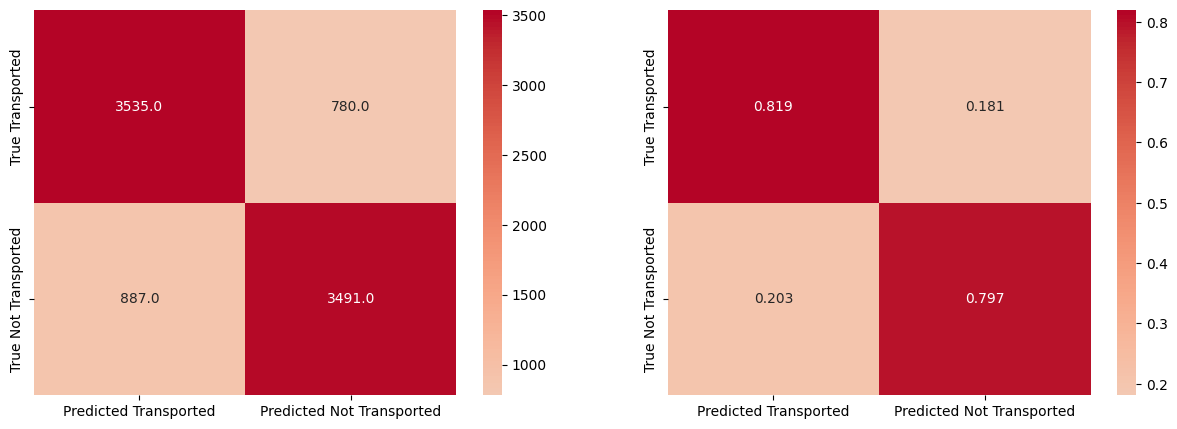

In [26]:
from sklearn.metrics import confusion_matrix
import itertools
print ("Accurancy: %.2f%% "%acc_random_forest)
y_pred_random_forest=clf.predict(X_train)
cnf_matrix = confusion_matrix(y_train, y_pred_random_forest)
cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

true_class_names = ['True Transported', 'True Not Transported']
predicted_class_names = ['Predicted Transported', 'Predicted Not Transported']

df_cnf_matrix = pd.DataFrame(cnf_matrix, index = true_class_names, columns = predicted_class_names)
df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, index = true_class_names, columns = predicted_class_names)

plt.figure(figsize = (15,5))
plt.subplot(121)
sns.heatmap(df_cnf_matrix, annot=True, cmap='coolwarm', center=0, fmt='.1f')
plt.subplot(122)
sns.heatmap(df_cnf_matrix_percent, annot=True, cmap='coolwarm', center=0, fmt='.3f')

Оформим в файл

In [27]:
submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Transported": y_pred})
submission['Transported'] = submission['Transported'].astype(bool)
submission.to_csv('submission.csv', index=False)

Сравним результаты трех методов: Логистической регрессии, Случайного леса и КатБуст

In [28]:
import yaml
import os

with open('params.yaml', 'r') as file:
    params=yaml.safe_load(file)

c=params['models']['logistic_regression']['C']
max_iter=params['models']['logistic_regression']['max_iter']
seed1=params['models']['logistic_regression']['random_state']

n_estimators=params['models']['random_forest']['n_estimators']
max_depth=params['models']['random_forest']['max_depth']
seed2=params['models']['random_forest']['random_state']

iterations=params['models']['catboost']['iterations']
lr=params['models']['catboost']['learning_rate']
depth=params['models']['catboost']['depth']


C:\Users\titen\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\titen\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


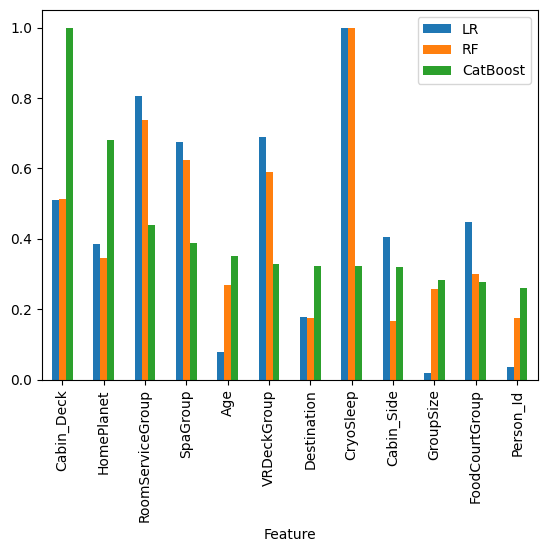

{'LogisticRegression': {'train_accuracy': 0.7456665132689063, 'test_accuracy': 0.7428702851885924}, 'RandomForest': {'train_accuracy': 0.8243595643503605, 'test_accuracy': 0.7608095676172953}, 'CatBoost': {'train_accuracy': 0.8271207240374291, 'test_accuracy': 0.764949402023919}}


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.utils.extmath import softmax
from sklearn.pipeline import make_pipeline
import json

def lr_pipeline():
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=max_iter, random_state = seed1, C=c))
    return model

def rf_pipeline():
    model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state = seed2))
    return model

def catboost_pipeline():
    model = make_pipeline(StandardScaler(), CatBoostClassifier(iterations=iterations, learning_rate=lr, depth=depth))
    return model

def feature_importances(df):
        
    X = df.drop('Transported', axis=1)
    y = df[['Transported']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
    
    # Logistic Regression    
    clf_lr = lr_pipeline()
    clf_lr.fit(X_train, y_train)
    coef_lr = clf_lr[1].coef_[0]
    
    acc_train_lr = accuracy_score(y_true=y_train, y_pred=clf_lr.predict(X_train))
    acc_test_lr = accuracy_score(y_true=y_test, y_pred=clf_lr.predict(X_test))
    label_lr = f'Importance (LR abs), acc_train = {acc_train_lr:.2%}, acc_test = {acc_test_lr:.2%}'
    
    # Random Forest
    clf_rf = rf_pipeline()
    clf_rf.fit(X_train, y_train)
    coef_rf = clf_rf[1].feature_importances_

    acc_train_rf = accuracy_score(y_true=y_train, y_pred=clf_rf.predict(X_train))
    acc_test_rf = accuracy_score(y_true=y_test, y_pred=clf_rf.predict(X_test))
    label_rf = f'Importance (LR abs), acc_train = {acc_train_rf:.2%}, acc_test = {acc_test_rf:.2%}'
    
    # CatBoost
    clf_cat = catboost_pipeline()
    clf_cat.fit(X_train, y_train, catboostclassifier__silent = True)
    coef_cat = clf_cat[1].feature_importances_
    
    acc_train_cat = accuracy_score(y_true=y_train, y_pred=clf_cat.predict(X_train).astype('bool'))
    acc_test_cat = accuracy_score(y_true=y_test, y_pred=clf_cat.predict(X_test).astype('bool'))
    label_cat = f'Importance (LR abs), acc_train = {acc_train_cat:.2%}, acc_test = {acc_test_cat:.2%}'

    
    feauture_importances = pd.DataFrame({
        'Feature': X.columns,
        'LR': np.abs(coef_lr),
        'RF': coef_rf,
        'CatBoost': coef_cat})
    
    feauture_importances = feauture_importances.sort_values(by = 'CatBoost', ascending=False)
    
    sc = MaxAbsScaler()
    feauture_importances[['LR']] = sc.fit_transform(feauture_importances[['LR']])
    feauture_importances[['RF']] = sc.fit_transform(feauture_importances[['RF']])
    feauture_importances[['CatBoost']] = sc.fit_transform(feauture_importances[['CatBoost']])
    
    # Plot everything
    
    feauture_importances.plot(kind='bar', x='Feature')
    plt.show()
    
    # Prepare return dictionary
    accuracy_metrics = {
        'LogisticRegression': {'train_accuracy': acc_train_lr, 'test_accuracy': acc_test_lr},
        'RandomForest': {'train_accuracy': acc_train_rf, 'test_accuracy': acc_test_rf},
        'CatBoost': {'train_accuracy': acc_train_cat, 'test_accuracy': acc_test_cat}}

    with open('metrics/accuracy_metrics.json', 'w') as f:
        json.dump(accuracy_metrics, f, indent=2)

    return accuracy_metrics

df2=train1
result = feature_importances(df2)
print(result)

Метод главных компонент

In [30]:
print(train1.head())
print(train1.shape)

   HomePlanet  CryoSleep  Destination  Age  Transported  Cabin_Deck  Cabin_Side  Person_Id  GroupSize  RoomServiceGroup  SpaGroup  VRDeckGroup  FoodCourtGroup
0           2          0            1    2            0           7           0          1          1                 0         0            0               0
1           1          0            1    1            1           4           1          1          1                 3         3            3               2
2           2          0            1    3            0           0           1          1          2                 3         3            3               3
3           2          0            1    2            0           0           1          2          2                 0         3            3               3
4           1          0            1    1            1           4           1          1          1                 3         3            2               3
(8693, 13)


In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [32]:
x = StandardScaler().fit_transform(train1)

In [33]:
covar_matrix = PCA(n_components = 12) #we have 4 features
covar_matrix.fit(x)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([24.1, 37.5, 48.9, 57.7, 65.4, 72.3, 78.8, 83.8, 88.3, 92.4, 95.9,
       98.2])

In [34]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
df_principal = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
df_principal.head()

,principal component 1,principal component 2,principal component 3,principal component 4
0,-0.061322,-0.686471,1.408294,-0.758228
1,-2.237778,-0.233554,-0.065037,0.581301
2,-3.247786,-0.059816,-0.259810,-0.124708
3,-2.204087,0.733651,-0.843458,0.590068
4,-2.227761,-0.230803,-0.021703,0.647239


In [35]:
df_all = pd.concat([df_principal, train1[['Transported']]], axis = 1)
df_all.head(5)

,principal component 1,principal component 2,principal component 3,principal component 4,Transported
0,-0.061322,-0.686471,1.408294,-0.758228,0
1,-2.237778,-0.233554,-0.065037,0.581301,1
2,-3.247786,-0.059816,-0.259810,-0.124708,0
3,-2.204087,0.733651,-0.843458,0.590068,0
4,-2.227761,-0.230803,-0.021703,0.647239,1


Explained variance: 
[3.13850858 1.73910739 1.48141056 1.14617245]
PCA effect: 
[[ 0.07158188  0.0834157   0.78357833 -0.2623643 ]
 [ 0.83432703 -0.17797911  0.09404974  0.10638963]
 [ 0.11832898 -0.10777582 -0.29488676  0.52925162]
 [-0.27835494 -0.17073393  0.41033715  0.24748175]
 [ 0.60484418 -0.06694151  0.26409027  0.34530859]
 [-0.13242493  0.13338046  0.71274622  0.25050316]
 [ 0.04179166  0.00942753  0.09165016  0.35884212]
 [ 0.24626003  0.88866819 -0.04734052  0.01172672]
 [ 0.27762181  0.88655576 -0.04653041  0.00634509]
 [-0.57421247 -0.0056825   0.09139037 -0.45335542]
 [-0.72578421  0.13625599  0.02153306  0.13259521]
 [-0.70649723  0.14421346 -0.06163123  0.25840605]
 [-0.68362383  0.14912673  0.00802204  0.35191271]]


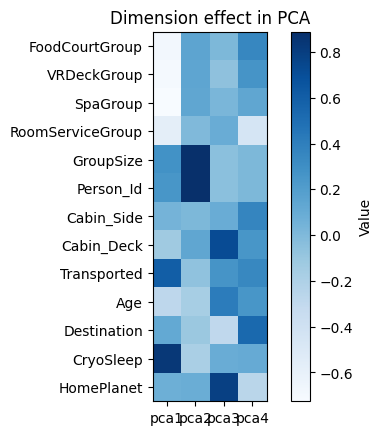

In [36]:
# оценим, какие размерности из исходного датасет наиболее близки к новым компонентам

print(f'Explained variance: \n{pca.explained_variance_}')

effect = pca.components_.T * np.sqrt(pca.explained_variance_)
print(f'PCA effect: \n{effect}')

plt.imshow(effect, cmap='Blues', origin='lower')
plt.colorbar(label='Value')
# Add titles and labels for clarity
plt.title('Dimension effect in PCA')
plt.xticks([0, 1, 2, 3], ['pca1', 'pca2', 'pca3', 'pca4'])
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12], train1.columns)

# Display the plot
plt.show()